<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feat%2Fexperiment-4/experiments/experiment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Prepare Colab, Define Constants

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#! ls
%cd drive/MyDrive/MachineLearning/
#! git clone https://github.com/emely3h/Geospatial_ML.git
%cd Geospatial_ML
! ls
! git pull
! git checkout feat/experiment-4

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  evaluation   jaccard_index  prepare_data  requirements.txt
data_exploration     experiments  models	 README.md
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 11 (delta 7), reused 10 (delta 7), pack-reused 0
Unpacking objects: 100% (11/11), 1.68 KiB | 1024 bytes/s, done.
From https://github.com/emely3h/Geospatial_ML
   6acbde4..ed36387  feat/experiment-4 -> origin/feat/experiment-4
   5956656..14e12d9  feature/fourier-transform -> origin/feature/fourier-transform
   9ad1077..0c4e8ba  main              -> origin/main
Updating 6acbde4..ed36387
Fast-forward
 evaluation/helpers.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)
Already on 'feat/experiment-4'
Your branch is u

In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import Sequence
from datetime import datetime
from models.unet_model import unet_2d
from data_exploration.mask_stats import Mask_Stats
from tensorflow.keras.models import load_model
from evaluation.evaluation_metrics_total import EvaluationMetricsTotal
from models.helpers import save_metrics, predictions_for_models
from evaluation.helpers import plot_loss_acc, calculate_save_metrics, load_metrics_into_df
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
total_tiles = 11121
train_tiles = 11063
val_tiles = 3545
test_tiles = 3699
data_path = "../data_colab/256_200"
experiment = "experiment_5"
batch_size = 32
tile_size = 256
step_size = 200

### 1. Create Data Generators

In [5]:
train_split_x = np.memmap(os.path.join(data_path, "train_split_x.npy"), mode="r", shape=(train_tiles, 256, 256, 5), dtype=np.uint8)
train_split_y = np.memmap(os.path.join(data_path, "train_split_y.npy"), mode="r", shape=(train_tiles, 256, 256), dtype=np.uint8)
val_split_x = np.memmap(os.path.join(data_path, "val_split_x.npy"), mode="r", shape=(val_tiles, 256, 256, 5), dtype=np.uint8)
val_split_y = np.memmap(os.path.join(data_path, "val_split_y.npy"), mode="r", shape=(val_tiles, 256, 256), dtype=np.uint8)
test_split_x = np.memmap(os.path.join(data_path, "test_split_x.npy"), mode="r", shape=(test_tiles, 256, 256, 5), dtype=np.uint8)
test_split_y = np.memmap(os.path.join(data_path, "test_split_y.npy"), mode="r", shape=(test_tiles, 256, 256), dtype=np.uint8)

train_stats = Mask_Stats(train_split_y)
train_stats.print_stats()
print()
val_stats = Mask_Stats(val_split_y)
val_stats.print_stats()
print()
test_stats = Mask_Stats(test_split_y)
test_stats.print_stats()

Shape: (11063, 256, 256)
Land pixels: 326666615  45.056 %
Valid pixels: 231026701  31.865 %
Invalid pixels: 167331452  23.079 %
Sum: 11063

Shape: (3545, 256, 256)
Land pixels: 100682317  43.337 %
Valid pixels: 76811432  33.062 %
Invalid pixels: 54831371  23.601 %
Sum: 3545

Shape: (3699, 256, 256)
Land pixels: 112712687  46.495 %
Valid pixels: 71301683  29.413 %
Invalid pixels: 58403294  24.092 %
Sum: 3699


In [6]:
class DataGenerator(Sequence):
    def __init__(self, mmap_x, mmap_y, batch_size):
        self.x_input = mmap_x
        self.y_mask = mmap_y
        self.batch_size = batch_size
        self.num_samples = self.x_input.shape[0]

    # returns number of batches as int    
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    # returns single batch
    def __getitem__(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]

        # normalization
        batch_inputs = batch_inputs/255
        # one-hot-encoding
        batch_masks = np.array([tf.one_hot(item, depth=3).numpy() for item in batch_masks])      
        
        # normalization + one hot encoding
        return batch_inputs, batch_masks
    
    def getitem_as_img(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]
        # normalization + one hot encoding
        return batch_inputs, batch_masks

In [7]:
# instanciate DataGenerators
batch_size = 32

train_generator = DataGenerator(train_split_x, train_split_y, batch_size)
val_generator = DataGenerator(val_split_x, val_split_y, batch_size)
test_generator = DataGenerator(test_split_x, test_split_y, batch_size)

print(train_generator.__len__())
print(val_generator.__len__())
print(test_generator.__len__())

346
111
116


In [8]:
train_batch = train_generator.__getitem__(9)
val_batch = val_generator.__getitem__(3)
test_batch = test_generator.__getitem__(4)

def print_batch_shapes(batch):
  print(type(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print()

# check batch shapes
print_batch_shapes(train_batch)
print_batch_shapes(val_batch)
print_batch_shapes(test_batch) 

# check normalization
print('Check normalization')
print(train_batch[1].max())
print(train_batch[1].min())

print(val_batch[1].max())
print(val_batch[1].min())

print(test_batch[1].max())
print(test_batch[1].min())

print()
# check one-hot-encoding
print('check one hot encoding')
print(train_batch[0].max())
print(train_batch[0].min())

print(val_batch[0].max())
print(val_batch[0].min())

print(test_batch[0].max())
print(test_batch[0].min())

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

Check normalization
1.0
0.0
1.0
0.0
1.0
0.0

check one hot encoding
1.0
0.0
1.0
0.0
1.0
0.0


### 2. Display Images

In [ ]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

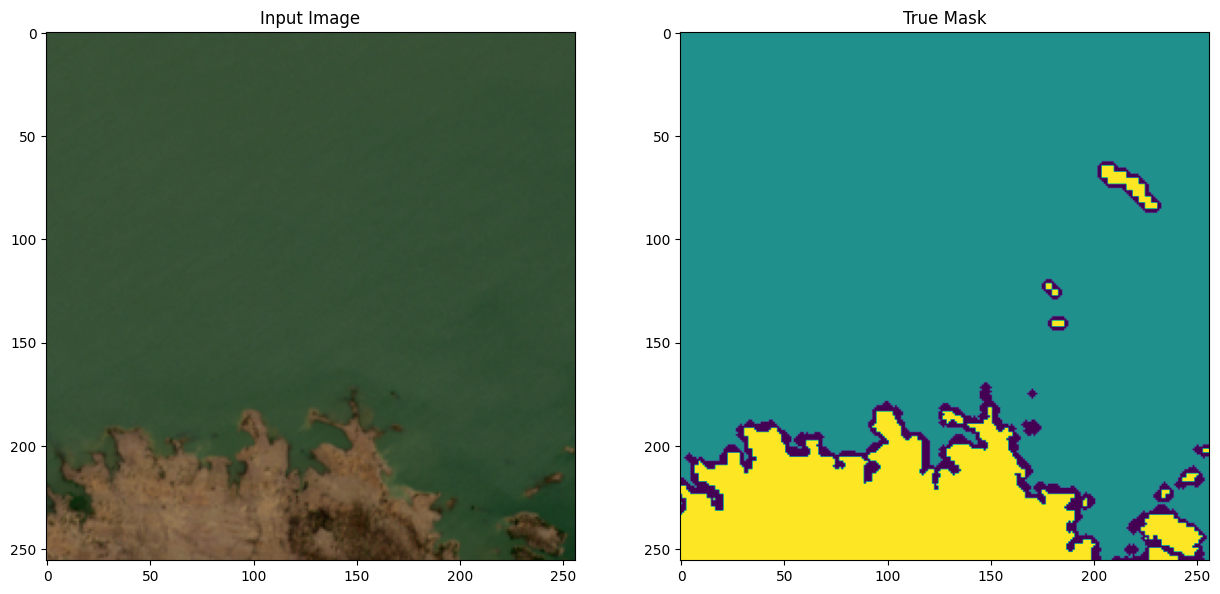

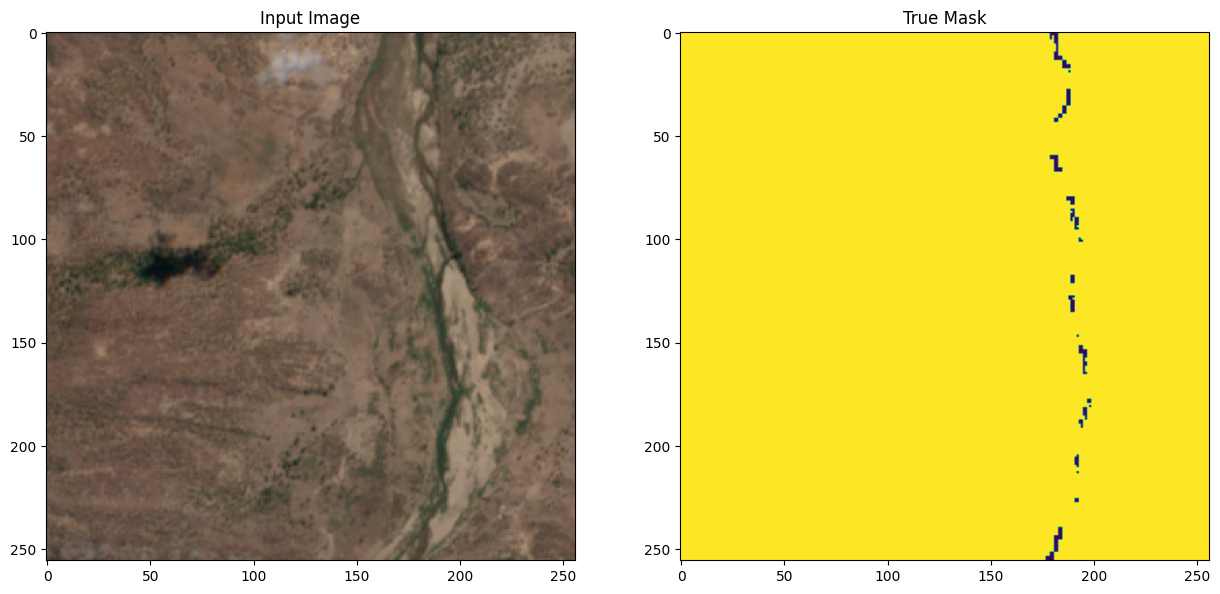

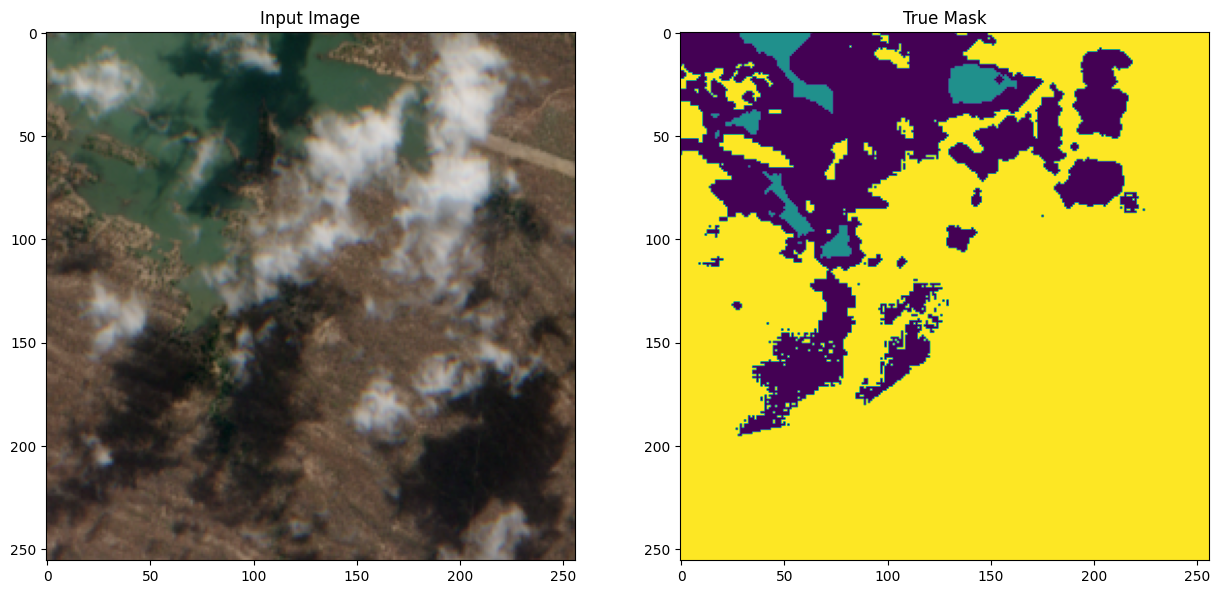

In [ ]:
train_batch_img = train_generator.getitem_as_img(10)

display(train_batch_img[0][:3], train_batch_img[1][:3])

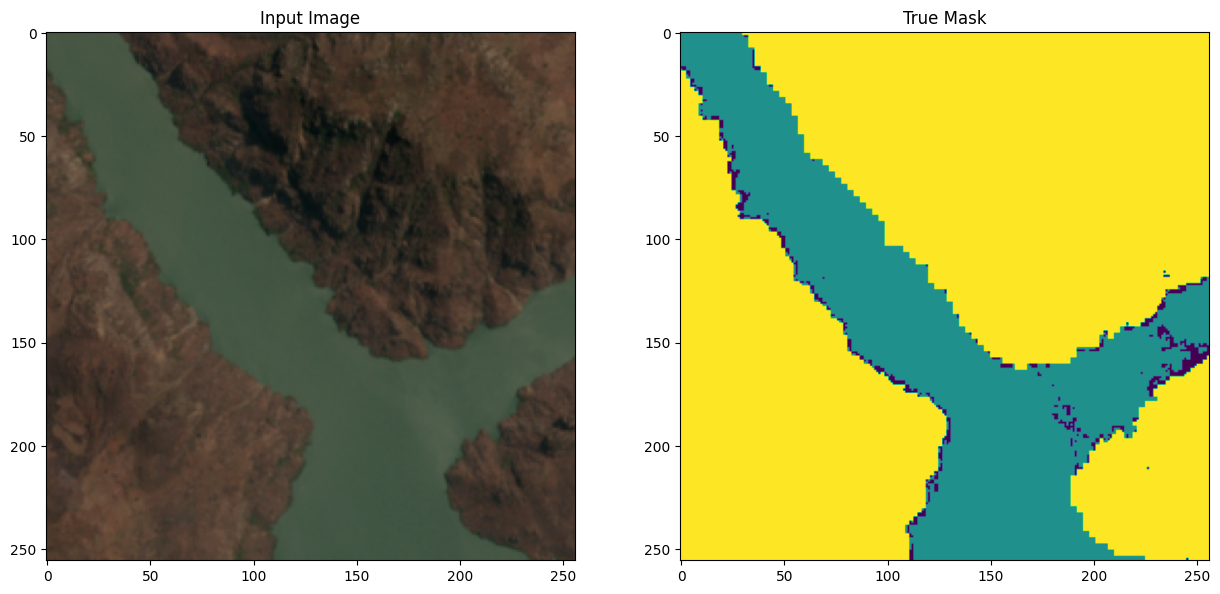

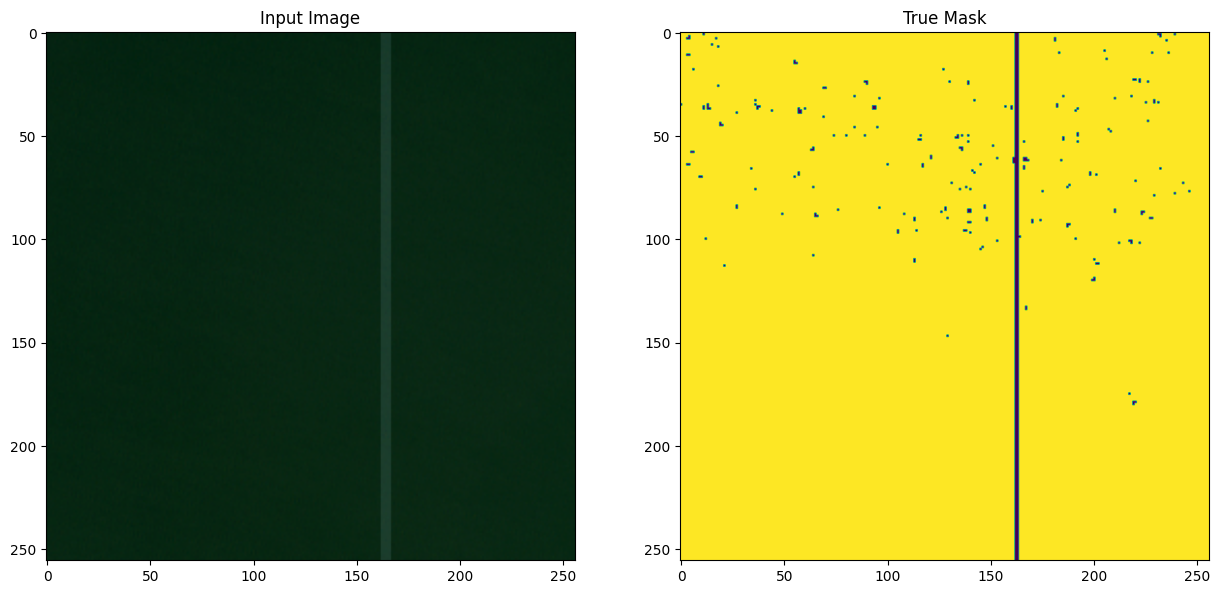

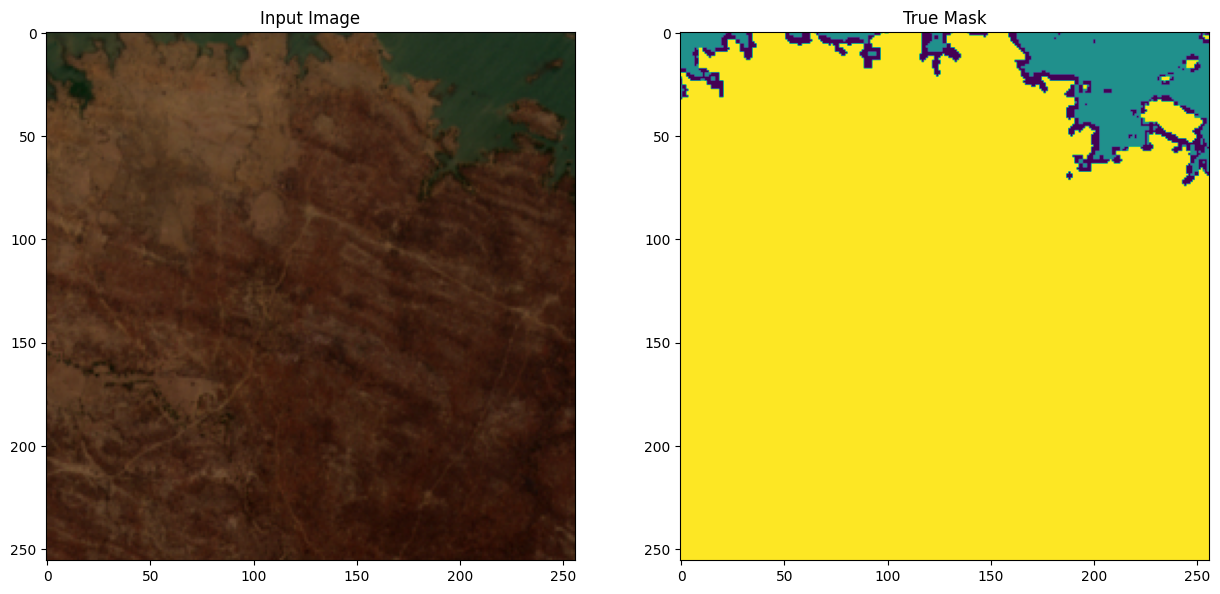

In [ ]:
val_batch_img = val_generator.getitem_as_img(2)

display(val_batch_img[0][:3], val_batch_img[1][:3])

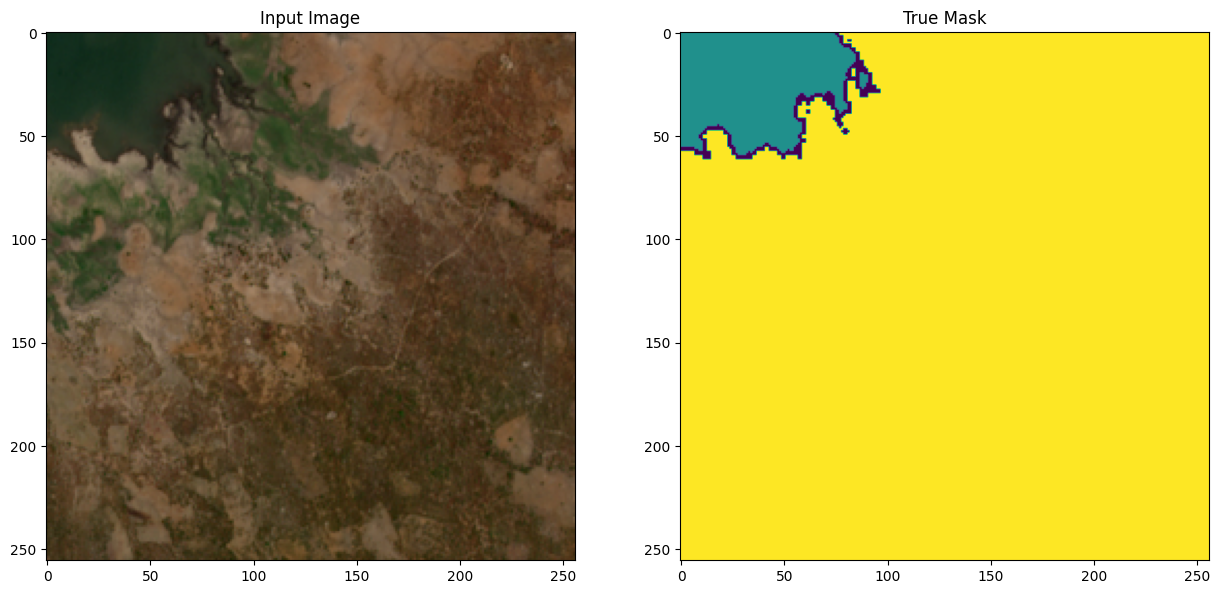

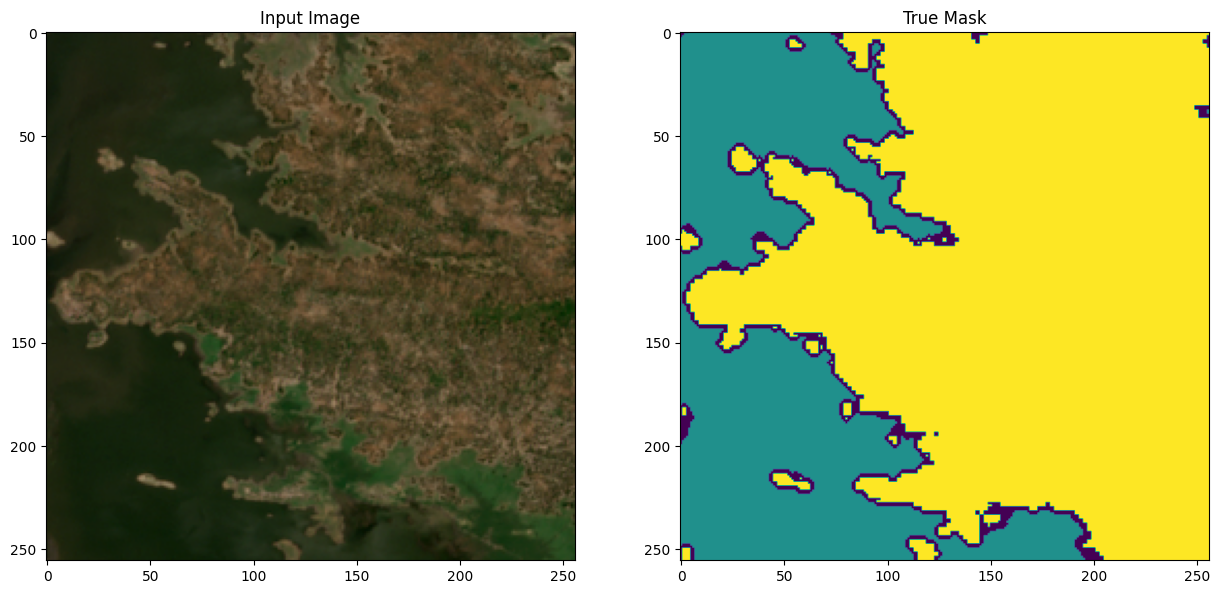

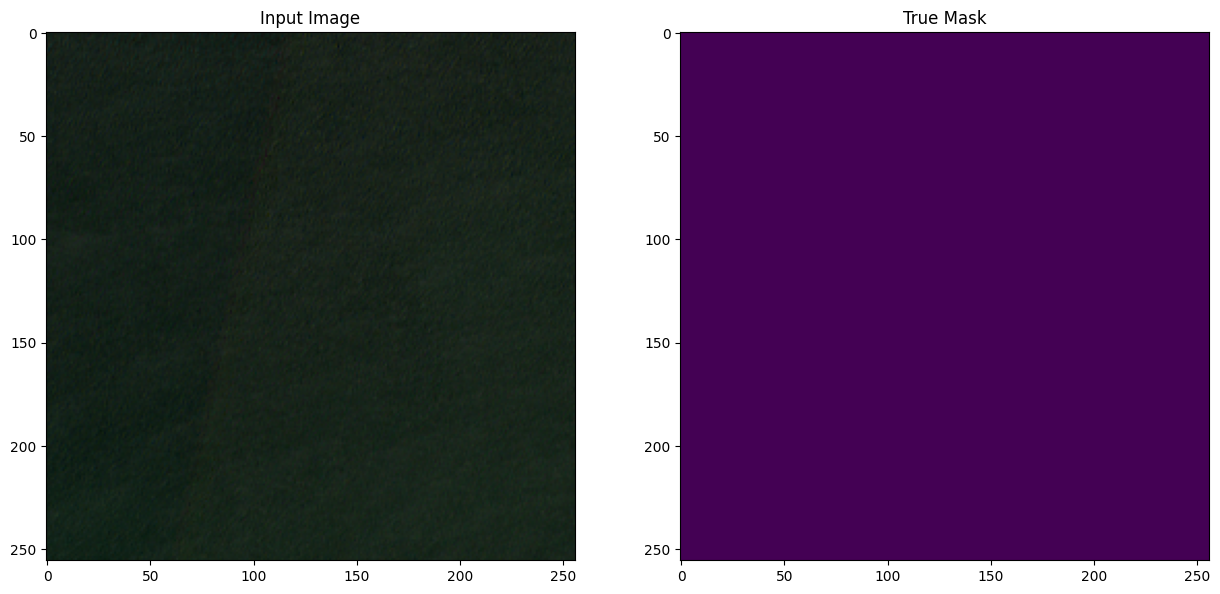

In [ ]:
test_batch_img = test_generator.getitem_as_img(4)

display(test_batch_img[0][:3], test_batch_img[1][:3])

### 3. Model training
execute with premium GPU, High RAM

In [ ]:
!nvidia-smi

Mon Apr 24 08:17:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |    693MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train_model(iterations, epochs=100):
  for i in range(iterations):
    print(f'Started training {i} at: {datetime.now()}')

    # del model

    # compiling model
    model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
    model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])
    #model.summary()

    model_name = f'{tile_size}_{step_size}_run_{i}'
    model_path = f'../models/{experiment}/model_{model_name}.h5'
    
    # model training
    early_stop_loss = EarlyStopping(monitor='val_loss', mode='min', patience=10)
    early_stop_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
    checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    model_history = model.fit(train_generator, epochs=100, validation_data=val_generator, 
                              callbacks=[early_stop_loss, early_stop_acc, checkpoint])

    # Save model history
    with open(f'../models/{experiment}/history_{model_name}.pkl', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    print('saving history completed')

    print(f'Finished at: {datetime.now()}')

In [ ]:
train_model(5)

Started training 0 at: 2023-04-24 08:17:11.421452
Epoch 1/100
346/346 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9246
Epoch 1: val_loss improved from inf to 0.16015, saving model to ../models/experiment_5/model_256_200_run_0.h5
346/346 [==============================] - 153s 363ms/step - loss: 0.2461 - accuracy: 0.9246 - val_loss: 0.1602 - val_accuracy: 0.9378
Epoch 2/100
346/346 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9603
Epoch 2: val_loss did not improve from 0.16015
346/346 [==============================] - 100s 288ms/step - loss: 0.1096 - accuracy: 0.9603 - val_loss: 0.1667 - val_accuracy: 0.9419
Epoch 3/100
346/346 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9596
Epoch 3: val_loss improved from 0.16015 to 0.13447, saving model to ../models/experiment_5/model_256_200_run_0.h5
346/346 [==============================] - 100s 289ms/step - loss: 0.1086 - accuracy: 0.9596 - val_loss: 0.1345 - val_

#### Summary

Available: 418.27 compute units
Usage rate: approximately 13.08 per hour


Available: 380.12 compute units
Usage rate: approximately 13.08 per hour

System RAM 10/83 GB
GPU RAM 18/40 GB 
Disk 30/166 GB

### Make predictions
Use standard GPU, standard RAM

In [ ]:
# predictions for all models
predictions_for_models(train_generator, val_generator, test_generator, experiment, train_tiles, val_tiles, test_tiles, batch_size, (0,5))

### Calculate + save metrics
No GPU, standard RAM

In [10]:
calculate_save_metrics(experiment, 0, train_split_y, val_split_y, test_split_y, train_tiles, val_tiles, test_tiles)
calculate_save_metrics(experiment, 1, train_split_y, val_split_y, test_split_y, train_tiles, val_tiles, test_tiles)
calculate_save_metrics(experiment, 2, train_split_y, val_split_y, test_split_y, train_tiles, val_tiles, test_tiles)
calculate_save_metrics(experiment, 3, train_split_y, val_split_y, test_split_y, train_tiles, val_tiles, test_tiles)
calculate_save_metrics(experiment, 4, train_split_y, val_split_y, test_split_y, train_tiles, val_tiles, test_tiles)

start calculating test metrics: 2023-04-26 13:34:31.788307
batch 0 2023-04-26 13:34:31.789131 start: 0 end: 1000
batch 1 2023-04-26 13:35:06.159489 start: 1000 end: 2000
batch 2 2023-04-26 13:35:34.524944 start: 2000 end: 3000
batch 3 2023-04-26 13:35:58.648610 start: 3000 end: 3699
start calculating validation metrics: 2023-04-26 13:36:11.649627
batch 0 2023-04-26 13:36:11.649898 start: 0 end: 1000
batch 1 2023-04-26 13:36:41.821659 start: 1000 end: 2000
batch 2 2023-04-26 13:37:21.880330 start: 2000 end: 3000
batch 3 2023-04-26 13:37:44.399877 start: 3000 end: 3545
start calculating training metrics: 2023-04-26 13:37:54.207427
batch 0 2023-04-26 13:37:54.207642 start: 0 end: 1000
batch 1 2023-04-26 13:38:19.800171 start: 1000 end: 2000
batch 2 2023-04-26 13:38:44.699072 start: 2000 end: 3000
batch 3 2023-04-26 13:39:07.309468 start: 3000 end: 4000
batch 4 2023-04-26 13:39:36.511924 start: 4000 end: 5000
batch 5 2023-04-26 13:39:57.789595 start: 5000 end: 6000
batch 6 2023-04-26 13:40

### History

#### model_0

In [ ]:
history = None
with open(f'../models/{experiment}/history_256_256_run_0.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.03335573896765709
Max training accuracy: 0.9884344935417175
Min validation loss: 0.08181668072938919
Max validation accuracy: 0.9709311127662659


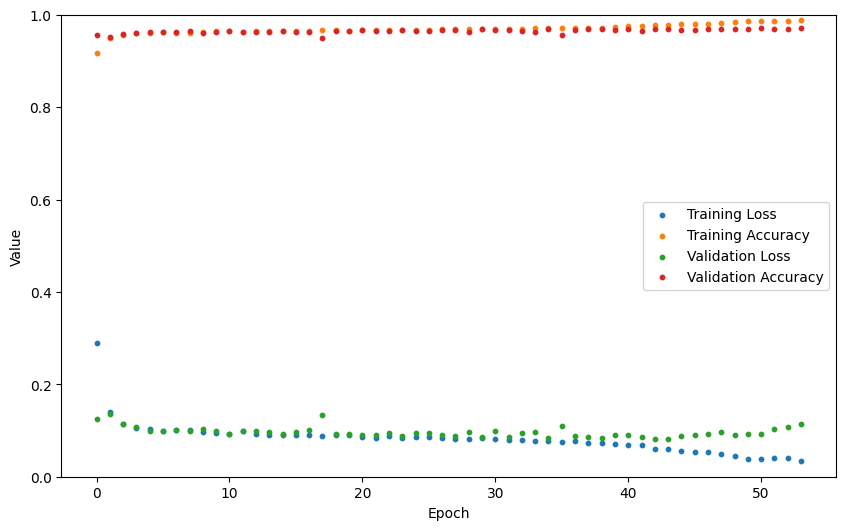

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, [0,1])

Min training loss: 0.03335573896765709
Min validation loss: 0.08181668072938919


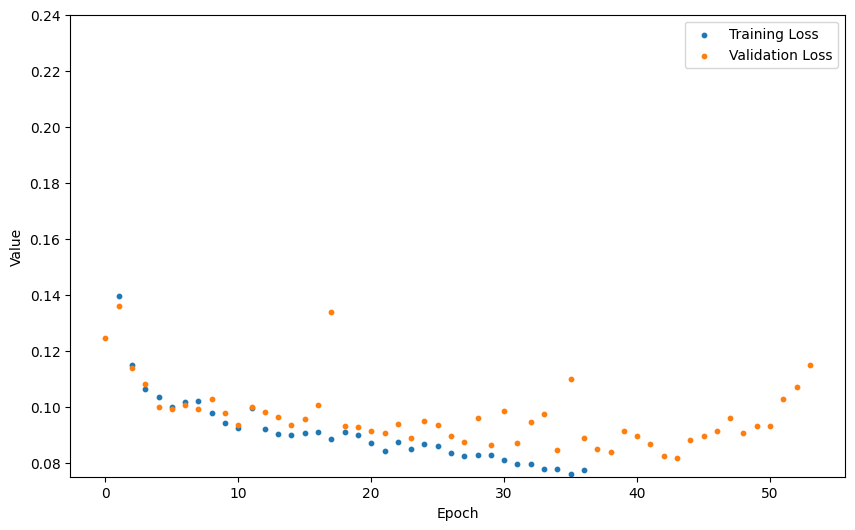

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss', history, [0.075, 0.24])

Max training accuracy: 0.9884344935417175
Max validation accuracy: 0.9709311127662659


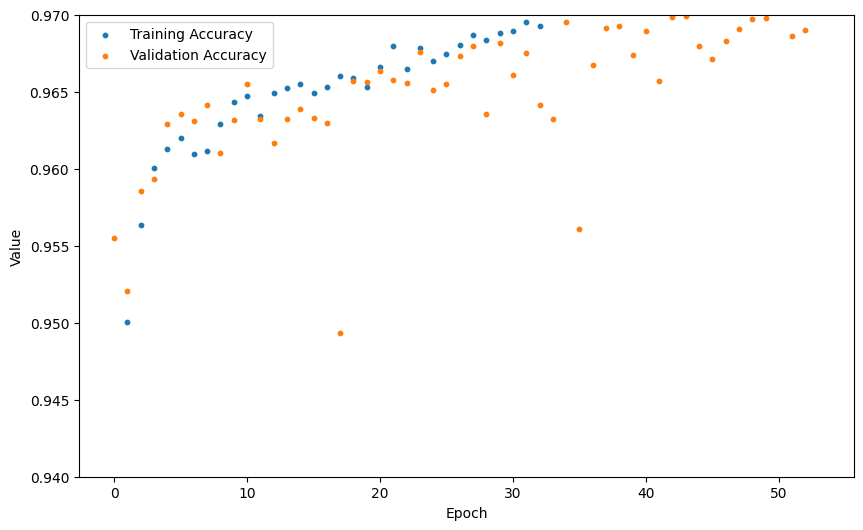

In [ ]:
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, [0.94, 0.97])

#### model_1

In [ ]:
history = None
with open(f'../models/{experiment}/history_256_256_run_1.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.0750376433134079
Max training accuracy: 0.9710356593132019
Min validation loss: 0.08586050570011139
Max validation accuracy: 0.9687614440917969


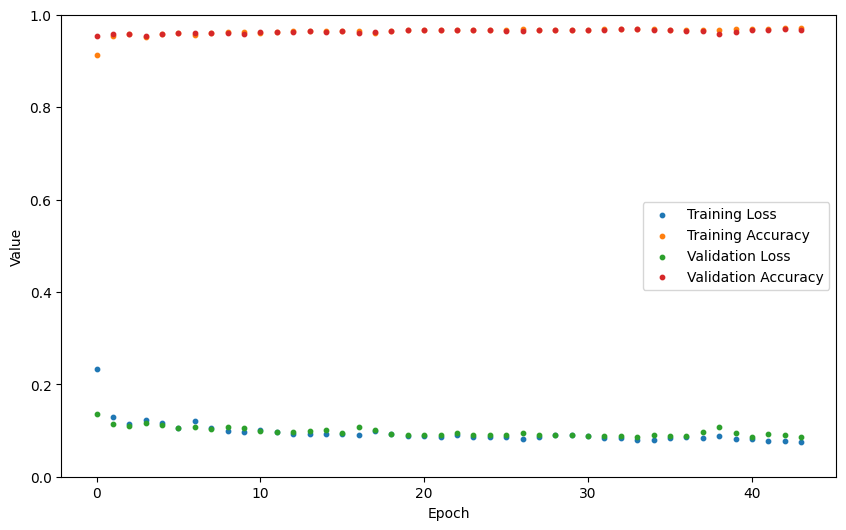

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, [0,1])

Min training loss: 0.0750376433134079
Min validation loss: 0.08586050570011139


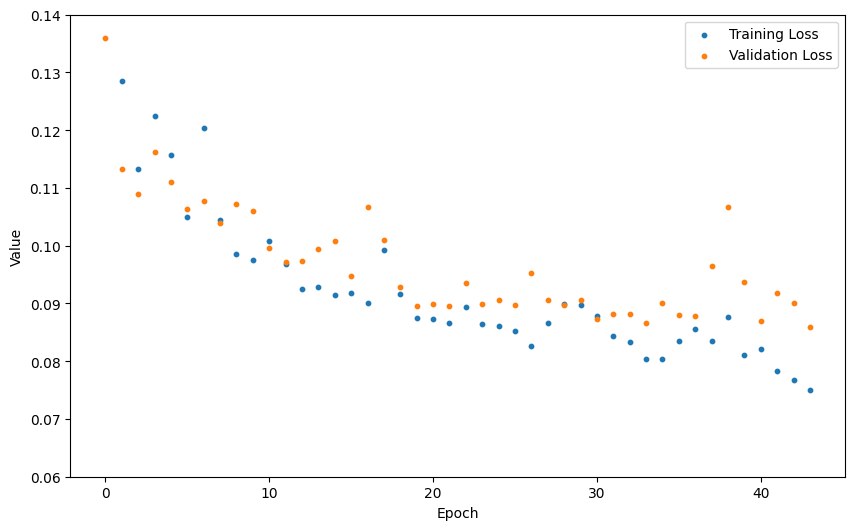

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss', history, [0.06, 0.14])

In [ ]:
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, [0.95, 1])

#### model_2

In [ ]:
history = None
with open(f'../models/{experiment}/history_256_256_run_2.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.0750376433134079
Max training accuracy: 0.9710356593132019
Min validation loss: 0.08586050570011139
Max validation accuracy: 0.9687614440917969


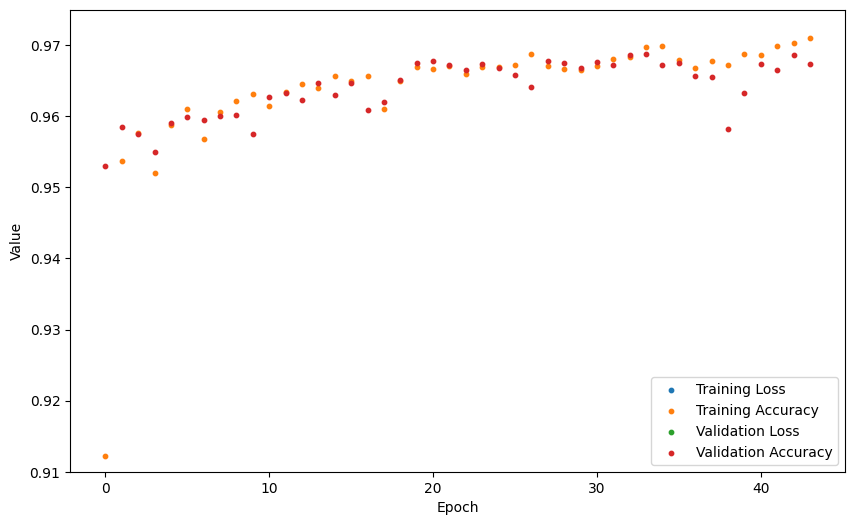

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, [0.91,0.975])

Min training loss: 0.0750376433134079
Min validation loss: 0.08586050570011139


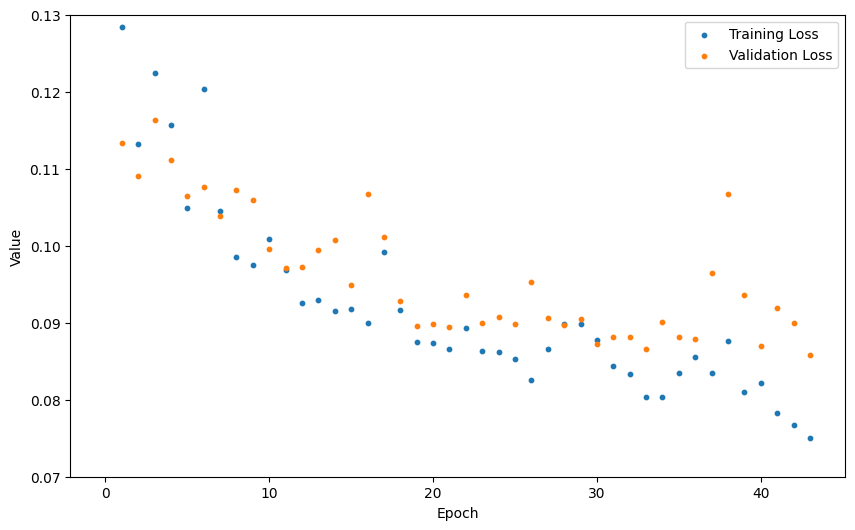

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss', history, [0.07, 0.130])

Max training accuracy: 0.9710356593132019
Max validation accuracy: 0.9687614440917969


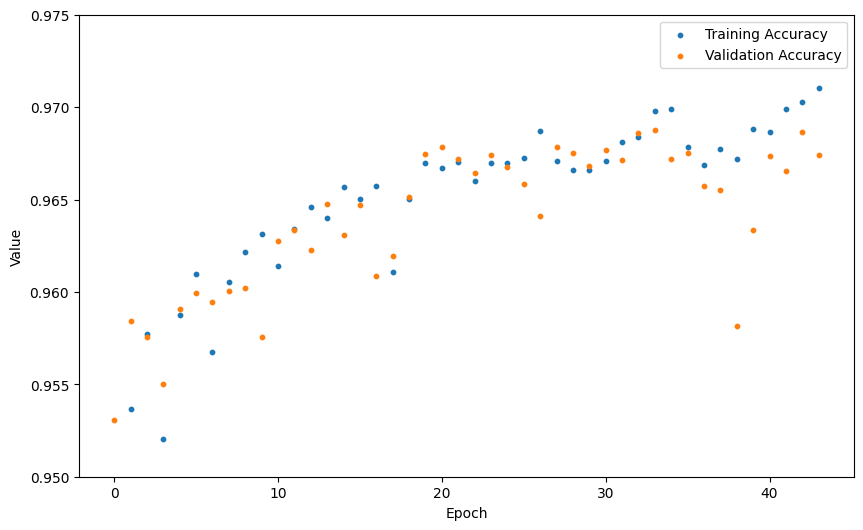

In [ ]:
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, [0.95, 0.975])

#### model_3

In [ ]:
history = None
with open(f'../models/{experiment}/history_256_256_run_3.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.0750376433134079
Max training accuracy: 0.9710356593132019
Min validation loss: 0.08586050570011139
Max validation accuracy: 0.9687614440917969


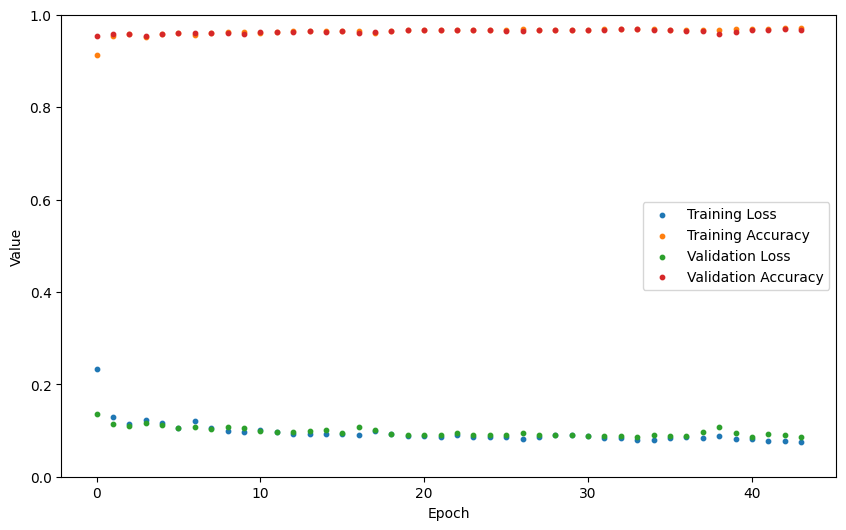

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, [0,1])

Min training loss: 0.0750376433134079
Min validation loss: 0.08586050570011139


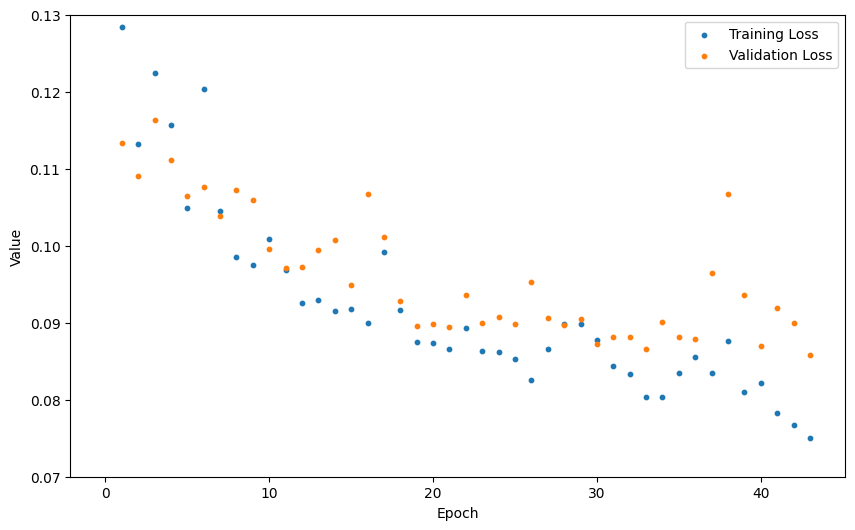

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss', history, [0.07, 0.130])

Max training accuracy: 0.9710356593132019
Max validation accuracy: 0.9687614440917969


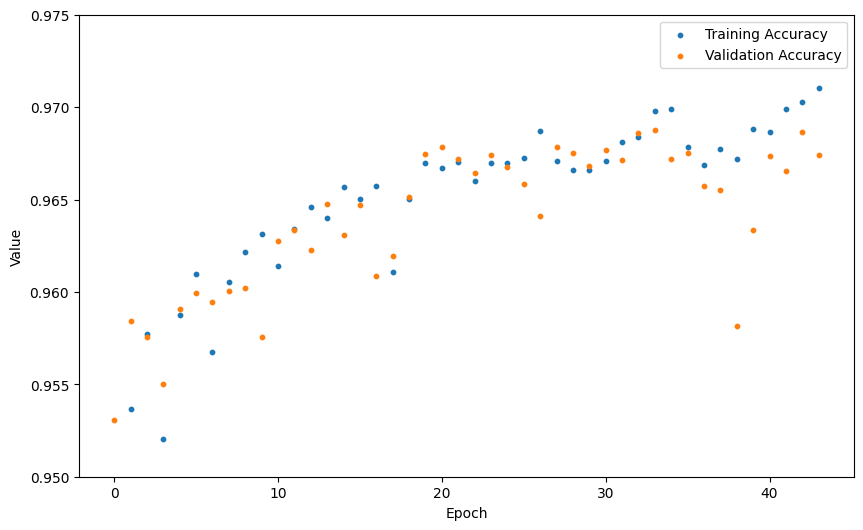

In [ ]:
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, [0.95, 0.975])

#### model_4

In [ ]:
history = None
with open(f'../models/{experiment}/history_256_256_run_4.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.0750376433134079
Max training accuracy: 0.9710356593132019
Min validation loss: 0.08586050570011139
Max validation accuracy: 0.9687614440917969


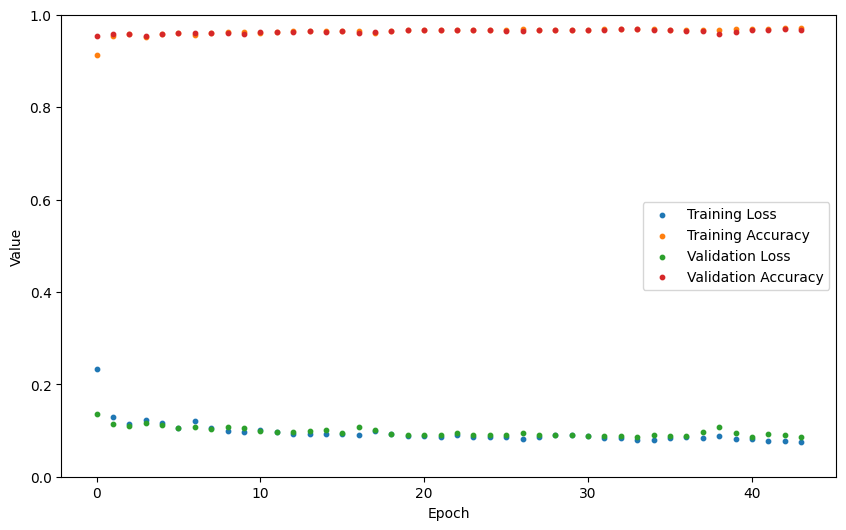

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, [0,1])

Min training loss: 0.0750376433134079
Min validation loss: 0.08586050570011139


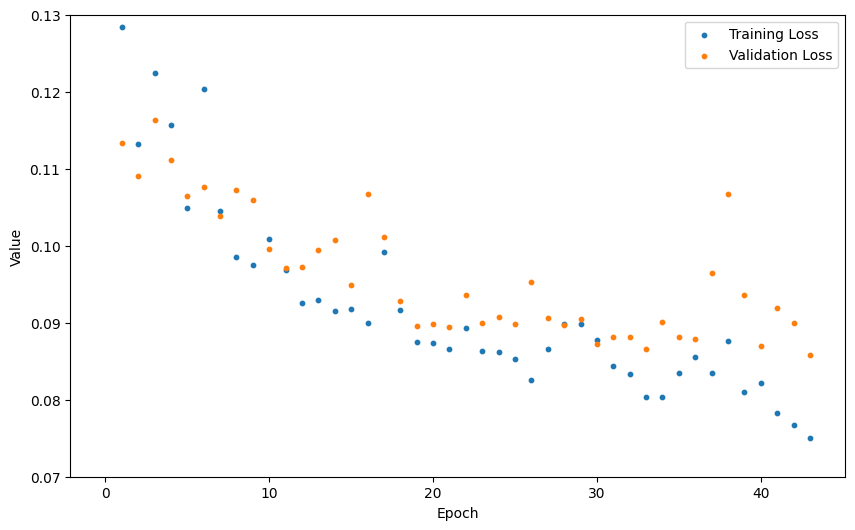

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss', history, [0.07, 0.130])

Max training accuracy: 0.9710356593132019
Max validation accuracy: 0.9687614440917969


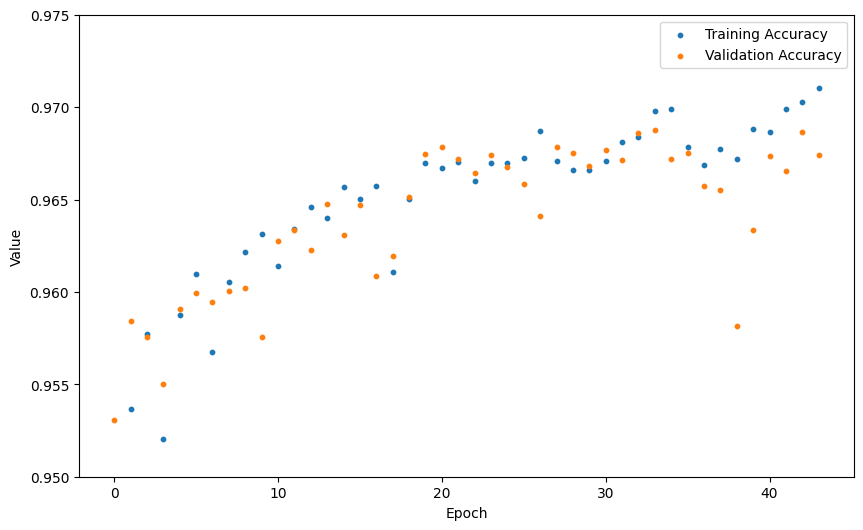

In [ ]:
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, [0.95, 0.975])

### Summary

In [9]:
df_exp_5 = load_metrics_into_df(experiment)
df_exp_5

load metrics_test_0.pkl
load metrics_train_0.pkl
load metrics_val_0.pkl
load metrics_test_1.pkl
load metrics_val_1.pkl
load metrics_train_1.pkl
load metrics_test_2.pkl
load metrics_val_2.pkl
load metrics_train_2.pkl
load metrics_test_3.pkl
load metrics_val_3.pkl
load metrics_train_3.pkl
load metrics_test_4.pkl
load metrics_val_4.pkl
load metrics_train_4.pkl


mean_jaccard  jaccard_invalid  jaccard_valid  jaccard_land  \
test_0       0.524681         0.431950       0.604366      0.583053   
train_0      0.938334         0.872581       0.907054      0.997633   
val_0        0.908117         0.814065       0.865422      0.999186   
test_1       0.928755         0.849793       0.891216      0.996415   
val_1        0.900297         0.795746       0.856343      0.998649   
train_1      0.936595         0.863380       0.908364      0.996573   
test_2       0.928783         0.853857       0.889214      0.996213   
val_2        0.909343         0.813291       0.868947      0.998993   
train_2      0.943113         0.878603       0.917070      0.996804   
test_3       0.945026         0.886487       0.914246      0.996873   
val_3        0.908020         0.810349       0.867345      0.998834   
train_3      0.949907         0.893034       0.926674      0.997185   
test_4       0.926227         0.845856       0.886070      0.996818   
val_4        0.911878         0.812460       0.875242      0.999014   
train_4      0.937375         0.863498       0.909541      0.997146   

         f1_invalid  f1_valid   f1_land  precision_invalid  precision_valid  \
test_0     0.603303  0.753402  0.736618           0.435034         0.980012   
train_0    0.931955  0.951262  0.998815           0.923285         0.957691   
val_0      0.897504  0.927857  0.999593           0.905006         0.922699   
test_1     0.918798  0.942480  0.998204           0.982258         0.901398   
val_1      0.886257  0.922613  0.999324           0.912785         0.905202   
train_1    0.926682  0.951982  0.998283           0.966401         0.927684   
test_2     0.921168  0.941359  0.998103           0.953594         0.919298   
val_2      0.897033  0.929879  0.999496           0.922999         0.912781   
train_2    0.935379  0.956741  0.998400           0.959221         0.942089   
test_3     0.939828  0.955202  0.998434           0.970174         0.934277   
val_3      0.895241  0.928960  0.999417           0.924176         0.910248   
train_3    0.943495  0.961942  0.998591           0.965255         0.948572   
test_4     0.916492  0.939594  0.998406           0.971310         0.903183   
val_4      0.896527  0.933471  0.999507           0.958605         0.896477   
train_4    0.926750  0.952628  0.998571           0.978228         0.921678   

         precision_land  sensitivity_invalid  sensitivity_valid  \
test_0         0.999057             0.983852           0.611909   
train_0        0.998955             0.940790           0.944918   
val_0          0.999404             0.890125           0.933072   
test_1         0.996972             0.863040           0.987484   
val_1          0.998905             0.861226           0.940706   
train_1        0.997088             0.890098           0.977586   
test_2         0.996623             0.890875           0.964503   
val_2          0.999158             0.872488           0.947629   
train_2        0.997155             0.912693           0.971857   
test_3         0.997216             0.911323           0.977087   
val_3          0.998898             0.868063           0.948459   
train_3        0.997412             0.922694           0.975693   
test_4         0.997304             0.867531           0.979064   
val_4          0.999222             0.842001           0.973650   
train_4        0.997540             0.880419           0.985729   

         sensitivity_land  specificy_invalid  specificy_valid  specificy_land  
test_0           0.583374           0.594479         0.994800        0.999521  
train_0          0.998676           0.976546         0.980477        0.999143  
val_0            0.999782           0.971137         0.961390        0.999544  
test_1           0.999440           0.995052         0.954990        0.997362  
val_1            0.999743           0.974579         0.951341        0.999162  
train_1          0.999482           0.990715         0